# Topic Modeling

In [1]:
# Basics
from collections import Counter
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

import re
import string
import datetime
import pickle 

# visualizations
from wordcloud import WordCloud

# nltk
import nltk
from nltk import FreqDist
from nltk.tokenize import word_tokenize
from nltk.util import ngrams
from nltk.corpus import stopwords, wordnet
from sklearn.decomposition import TruncatedSVD
from sklearn.pipeline import Pipeline

#sklearn
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer

# spacy
import spacy

# corex
from corextopic import corextopic as ct
from corextopic import vis_topic as vt

from preprocessing_funcs import clean_tweet, get_hashtags, get_emojis

In [2]:
with open('../data_files/processed_tweets.pickle', 'rb') as read_file:
    tweets = pickle.load(read_file)

In [3]:
tweets.head()

,text,processed
0,#IslamKills Are you trying to say that there w...,islam kill try say terrorist attack europe ref...
1,"Clinton: Trump should’ve apologized more, atta...",clinton trump apologize attack little
2,RT @ltapoll: Who was/is the best president of ...,well president past retweet
3,RT @jww372: I don't have to guess your religio...,guess religion christmas aftermath
4,RT @Shareblue: Pence and his lawyers decided w...,pence lawyer decide official email public can see


In [4]:
tweets.tail()

,text,processed
203477,"RT @AndreaChalupa: In intel circles, the story...",intel circle story go fsb film trump orgy russ...
203478,RT @KansasCityDNews: Tonganoxie police: Middle...,tonganoxie police middle school girl sexually ...
203479,RT @signsinyork: Getting the right #company lo...,get right company logo business get message ac...
203480,The Latest: Obama affirms continuity of ties w...,late obama affirm continuity tie canada
203481,RT @futureguru100: U cant just Upload a CD onl...,u can not upload cd online product work u get ...


In [5]:
tweets.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 203482 entries, 0 to 203481
Data columns (total 2 columns):
 #   Column     Non-Null Count   Dtype 
---  ------     --------------   ----- 
 0   text       203482 non-null  object
 1   processed  203482 non-null  object
dtypes: object(2)
memory usage: 3.1+ MB


In [6]:
tweets.head()

,text,processed
0,#IslamKills Are you trying to say that there w...,islam kill try say terrorist attack europe ref...
1,"Clinton: Trump should’ve apologized more, atta...",clinton trump apologize attack little
2,RT @ltapoll: Who was/is the best president of ...,well president past retweet
3,RT @jww372: I don't have to guess your religio...,guess religion christmas aftermath
4,RT @Shareblue: Pence and his lawyers decided w...,pence lawyer decide official email public can see


## Topic Modeling

In [7]:
proc_tweets = tweets.processed

### LSA

In [8]:
%%time

vectorizer = TfidfVectorizer(use_idf=True, 
                             smooth_idf=True, 
                             #ngram_range=(1, 3),
                             max_features=10000,
                            stop_words='english')

svd_model = TruncatedSVD(n_components=3, 
                        algorithm='randomized',
                        n_iter=100,
                        random_state=42)

# pipeline of tf-idf + SVD, fit and applied to docs: 

svd_transformer = Pipeline([('tfidf', vectorizer),
                           ('svd', svd_model)])

svd_matrix = svd_transformer.fit_transform(proc_tweets)

CPU times: user 1min 28s, sys: 3.68 s, total: 1min 32s
Wall time: 9.93 s


In [9]:
terms = vectorizer.get_feature_names()

for ix, comp in enumerate(svd_model.components_):
    terms_comp = zip(terms, comp)
    sorted_terms = sorted(terms_comp, key= lambda x:x[1], reverse=True)[:10]
    print("Topic "+str(ix)+": ")
    for t in sorted_terms:
        print(t[0])
    print("")

Topic 0: 
trump
donald
hillary
clinton
real
president
say
america
make
obama

Topic 1: 
hillary
clinton
email
thing
debate
obama
campaign
trust
crook
know

Topic 2: 
make
america
people
like
great
obama
know
say
good
love



In [10]:
vectorizer = CountVectorizer(max_features=10000,
                             binary=True, 
                            stop_words='english')

svd_model = TruncatedSVD(n_components=4, 
                        algorithm='randomized',
                        n_iter=200,
                        random_state=42)

# pipeline of tf-idf + SVD, fit and applied to docs: 

svd_transformer = Pipeline([('cv', vectorizer),
                           ('svd', svd_model)])

svd_matrix = svd_transformer.fit_transform(proc_tweets)

In [11]:
terms = vectorizer.get_feature_names()

for ix, comp in enumerate(svd_model.components_):
    terms_comp = zip(terms, comp)
    sorted_terms = sorted(terms_comp, key= lambda x:x[1], reverse=True)[:10]
    print("Topic "+str(ix)+": ")
    for t in sorted_terms:
        print(t[0])
    print("")

Topic 0: 
trump
donald
hillary
clinton
real
say
president
obama
politic
america

Topic 1: 
hillary
clinton
obama
email
campaign
fbi
say
debate
crook
lie

Topic 2: 
obama
make
say
america
people
like
tcot
president
pjnet
black

Topic 3: 
donald
real
make
hillary
america
great
people
like
wake
tcot



### Corex

[lecture example notebook](https://github.com/scrapfishies/onl20_ds4/blob/master/curriculum/project-04/fancy-nlp/corex/CorEx.ipynb)

In [12]:
vectorizer = CountVectorizer(max_features=20000,
                             token_pattern="\\b[a-z][a-z]+\\b",
                             binary=True,
                             stop_words='english')

doc_word = vectorizer.fit_transform(proc_tweets)
words = list(np.asarray(vectorizer.get_feature_names()))

In [13]:
# n_hidden is the number of topics
# words is your list of words used in your corpus
# I recommend adding docs=df.data to make it easier to check which sentences are in each resulting topic

topic_model = ct.Corex(n_hidden=6, 
                       words=words,
                       max_iter=200, 
                       seed=42)


topic_model.fit(doc_word, words=words, docs=proc_tweets)

In [14]:
# Print all topics from the CorEx topic model
topics = topic_model.get_topics()
for n,topic in enumerate(topics):
    topic_words,_ = zip(*topic)
    print('{}: '.format(n) + ', '.join(topic_words))

0: trump, hillary, clinton, donald, obama, real, president, politic, campaign, gop
1: merkel, muss, die, ist, oscar, color, es, das, sie, ich
2: pjnet, tcot, ccot, mt, cruz, ted, tea, survival, thanksgiving, guide
3: police, state, new, russia, report, foundation, post, tax, security, health
4: email, fbi, dnc, white, poll, medium, wikileaks, house, sander, kaine
5: make, people, like, black, matt, live, hate, phrase, great, idea


In [15]:
# Let's check out topic : graphics
topic_model.get_top_docs(topic=5, n_docs=5)

[('gift idea politician stand people shoe get real feel lack basic human need actualre',
  0.0),
 ('ruin dinner one phrase outta mind think aunt rebecca go away retreat say go',
  0.0),
 ('emancipate thinker afraid write foolish thing anton pavlovich chekhov',
  0.0),
 ('ruin dinner one phrase news think pet rat escape good news fairly certain raisin',
  0.0),
 ('time put game face france mlp officiel makefrancegreatagain', 0.0)]

In [16]:
# Note, instead of using .predict(doc_word), you can also call topic_model.labels
predictions = pd.DataFrame(topic_model.predict(doc_word), columns=['topic'+str(i) for i in range(6)])
predictions.head()

,topic0,topic1,topic2,topic3,topic4,topic5
0,True,False,False,False,False,False
1,True,False,False,False,False,False
2,True,False,False,False,False,False
3,False,False,False,False,False,False
4,True,False,False,True,True,False


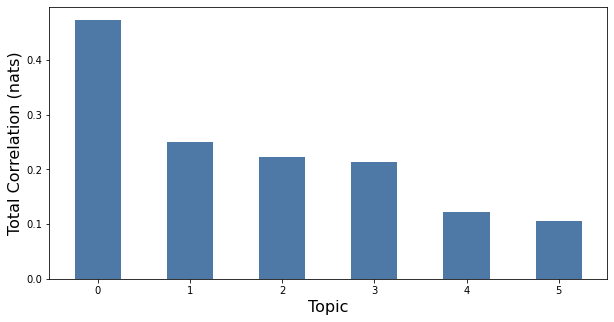

In [17]:
%matplotlib inline 

plt.figure(figsize=(10,5))
plt.bar(range(topic_model.tcs.shape[0]), topic_model.tcs, color='#4e79a7', width=0.5)
plt.xlabel('Topic', fontsize=16)
plt.ylabel('Total Correlation (nats)', fontsize=16)
plt.show()

In [18]:
topic_model.fit(doc_word, words=words, docs=proc_tweets, 
                anchors=[['trump', 'donald', 'maga', 'rep', 'republican', 'gop'], 
                         ['hillary', 'clinton', 'email', 'democrat', 'dnc'], 
                         ['black', 'live', 'police'], 
                         ['obama', 'barack'],
                         ['isis', 'islam', 'muslim'], 
                         ['politic', 'debate', 'news', 'election', 'fox', 'cnn']], 
                anchor_strength=2)

# Print all topics from the CorEx topic model
topics = topic_model.get_topics()
for n,topic in enumerate(topics):
    topic_words,_ = zip(*topic)
    print('{}: '.format(n) + ', '.join(topic_words))

0: trump, donald, gop, maga, real, republican, president, supporter, train, poll
1: hillary, clinton, email, dnc, crook, campaign, fbi, foundation, wikileaks, trust
2: black, live, police, matt, officer, oscar, color, white, cop, shoot
3: obama, pjnet, tcot, ccot, cruz, mt, barack, ted, tea, america
4: islam, isis, muslim, refugee, kill, terrorist, muslims, brussels, islamic, attack
5: news, politic, debate, election, cnn, fox, topic, reject, alternative, post


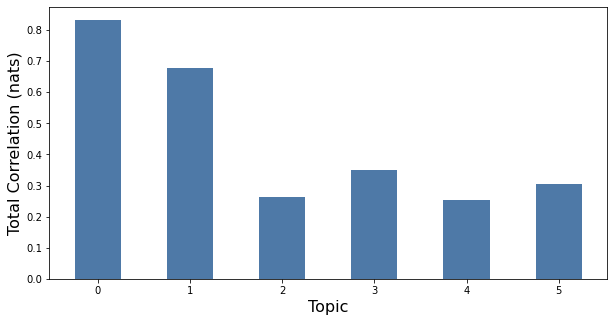

In [19]:
plt.figure(figsize=(10,5))
plt.bar(range(topic_model.tcs.shape[0]), topic_model.tcs, color='#4e79a7', width=0.5)
plt.xlabel('Topic', fontsize=16)
plt.ylabel('Total Correlation (nats)', fontsize=16)
plt.show()

In [20]:
# Let's check out topic : graphics
topic_model.get_top_docs(topic=0, n_docs=5)

[('trump presidential force strong real donald trump trump train', 0.0),
 ('would sign petition ask donald trump take step prosecute hillary chance',
  0.0),
 ('true story donald trump mock reporter disability via', 0.0),
 ('gop lawmaker americans rule regulatory superstate tcot wake america maga pjnet',
  0.0),
 ('fakemusicaltheaterfacts real donald trump still piss new york time refuse hire theater critic',
  0.0)]

In [21]:
topic_model.fit(doc_word, words=words, docs=proc_tweets, 
                anchors=[['trump', 'donald'],
                         ['trump', 'donald'], 
                         ['trump', 'donald'], 
                         ['hillary', 'clinton'],
                         ['hillary', 'clinton'], 
                         ['hillary', 'clinton']
                        ], 
                anchor_strength=6)

# Print all topics from the CorEx topic model
topics = topic_model.get_topics()
for n,topic in enumerate(topics):
    topic_words,_ = zip(*topic)
    print('{}: '.format(n) + ', '.join(topic_words))

0: trump, donald, president, poll, say, midnight, america, anti, tower, lead
1: trump, donald, real, supporter, maga, rally, medium, support, melania, vote
2: trump, donald, politic, train, headline, favorite, celebrate, voter, endorse, immigration
3: hillary, clinton, campaign, crook, debate, prison, birtherism, birther, donor, thing
4: hillary, clinton, trust, juanita, broaddrick, cheryl, rape, tamper, thank, msnbc
5: hillary, clinton, email, foundation, fbi, wikileaks, benghazi, lie, server, pneumonia


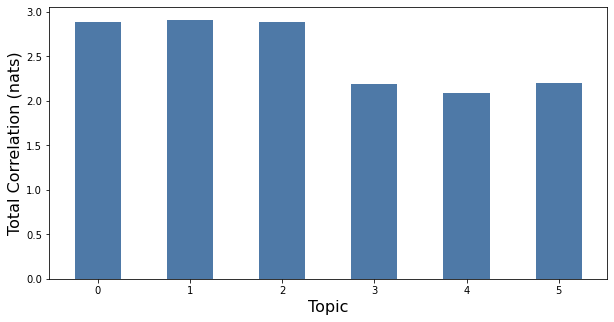

In [22]:
plt.figure(figsize=(10,5))
plt.bar(range(topic_model.tcs.shape[0]), topic_model.tcs, color='#4e79a7', width=0.5)
plt.xlabel('Topic', fontsize=16)
plt.ylabel('Total Correlation (nats)', fontsize=16)
plt.show()